<img src="https://raw.githubusercontent.com/UCLAMAEThreads/FluidDynTools.jl/main/notebook/logo_UCLA_blue_boxed.svg" alt="ucla logo" width="150" align="left"/>

### **Introduction to Fluid Dynamics**
<hr />

# General potential flows around bodies in 2D (continued)
Now that we have seen that conformal maps can generate interesting shapes,
we would like to use them to solve potential flow problems.

In complex notation, a planar potential flow is specified by the **complex potential**,
which consolidates the scalar potential and streamfunction together:

$$F(z) = \phi + \mathrm{i}\psi$$

This, like the conformal transform $z(\zeta)$, is a *holomorphic* (or analytic)
function, so it can be differentiated with respect to $z$. This derivative
gives us the *complex velocity*, $w$.

$$\dfrac{\mathrm{d}F}{\mathrm{d}z} = w(z) = u - \mathrm{i} v$$

Note the minus sign, which is unavoidable.

Remember that we are solving the problem in the circle plane, not the physical
plane. Suppose that we have found the complex potential in the circle plane for our
desired flow, $\hat{F}(\zeta)$. Then, the solution in the physical plane is
**easily** obtained by a composite of the potential and the inverse conformal
transform, $\zeta(z)$:

$$F(z) = \hat{F}(\zeta(z))$$

If we want the velocity in the physical plane, we just use the chain rule.

$$w(z) = \dfrac{\mathrm{d}\hat{F}}{\mathrm{d}\zeta} \dfrac{\mathrm{d}\zeta}{\mathrm{d}z}$$

Another consequence of using a conformal transform is that $\mathrm{d}\zeta/\mathrm{d}z = 1/z'(\zeta)$.
So the velocity is just

$$w(z) = \dfrac{1}{z'(\zeta)} \hat{w}(\zeta)$$

(We have not explictly written it, but we should assume that each $\zeta$ on the right
side is given by the inverse mapping, $\zeta(z)$.)

In [1]:
using FluidDynTools

In [2]:
using PotentialFlow
using PotentialFlow.Bodies
import PotentialFlow: RigidBodyMotion

In [3]:
using Plots

## Set up the body
Let's choose an elliptical body to illustrate examples of the flow.
We will also create a Cartesian grid of points to evaluate the streamfunction
in the physical ($z$) plane. We also need to inverse-transform these grid points
to the $\zeta$ plane, because each of the flow field solutions are obtained in the circle
plane.

In [4]:
a, b = 1, 0.1
ccoeff = ComplexF64[0.5(a+b), 0, 0.5(a-b)]
Zr = 0.0+0.0im
α = -π/4
b = ConformalBody(ccoeff,Zr,α)

Body generated by: Power series map

  centroid at 0.0 + 0.0im
  angle -0.7854


Set up the grid and transform each point to the $\zeta$ plane. This
last step can be slow for some shapes.

In [5]:
xg = range(-2,2,length=101)
yg = range(-2,2,length=101)
zg = [x + im*y for y in yg, x in xg]
ζg = inverse_conftransform(zg,b);

## Example 1: A point vortex near a stationary body
Let's first look at a vortex placed near the body. We will specify
body motion here, as well, but the motion will be zero.

In [6]:
t = 0 # time is irrelevant here, but it is an argument in the function
Żr = 0.0+0.0im # translational velocity
α̇ = 0.0 # angular velocity
motion = RigidBodyMotion(Żr, α̇)

Rigid Body Motion:
  ċ = 0.0 + 0.0im
  c̈ = 0.0 + 0.0im
  α̇ = 0.0
  α̈ = 0.0
  Constant (ċ = 0.0 + 0.0im, α̇ = 0.0)

We place a vortex of strength 1 at a certain point. Before using it, we need to
inverse-transform it to the circle plane

In [7]:
zv = 0.7-0.2im
Γv = 1.0
vort_z = Vortex.Point(zv, Γv)
sys = (vort_z,)
sys = inverse_conftransform(sys,b)

(Vortex.Point(0.8108453499374294 + 1.1218756307944868im, 1.0),)

Now we account for the body's presence. This is done by the function `enforce_no_flow_through!`,
which solves the problem by creating an image inside the circle at $1/\zeta_{v}^{*}$
of strength $-\Gamma_{v}$.
(It does *not* create an image at the center of the circle, however. So the total
circulation of this vortex and its image is zero.) Note that we use the `clear_images!`
function to get rid of any images set up previously. There were none in this case,
but it is a good habit.

In [8]:
clear_images!(b)
enforce_no_flow_through!(b, motion, sys, t)

Now we are ready to plot the streamlines. There is a handy function `streamlines`
that does this. It simply calls a function `PotentialFlow.streamfunction`
and evaluates the streamfunction in the circle plane, using the points in `ζg`,
and then plots the results on the corresponding Cartesian grid in the physical plane.

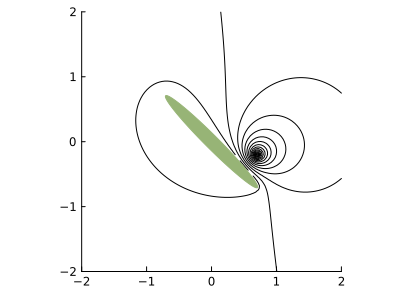

In [9]:
ps = streamlines(xg,yg,ζg,(b,sys),levels=range(-0.5,0.5,length=31),xlim=(-2,2),ylim=(-2,2))
plot!(ps,b)

It is clear that the normally circular streamlines around the vortex have
been deformed by the presence of the body, and no-flow-through
is visually satisfied.

## Example 2: Free stream past the body
Now let's put the body in a free stream of speed 1. Like the vortex, we have
to inverse-transform this free stream to the circle plane,
and then call `enforce_no_flow_through!`. This places an image
in the body -- in this case, a doublet at the center of the circle.

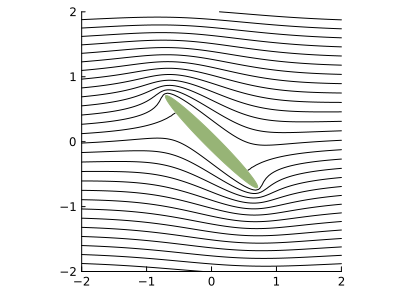

In [10]:
Winf = 1.0 + 0.0im
fs = Freestreams.Freestream(conj(Winf))
sys = (fs,)
sys = inverse_conftransform(sys,b)

clear_images!(b)
enforce_no_flow_through!(b, motion, sys, t)

ps = streamlines(xg,yg,ζg,(b,sys),levels=range(-2,2,length=31),xlim=(-2,2),ylim=(-2,2))
plot!(ps,b)

## Example 3: Body in translation
In this example and the next, the body will be in motion in an otherwise
quiescent flow. Let's make it move to the left with speed 1. This is the same
problem we solved with the freestream, but now in a different reference frame.
There are no other contributors to the problem, so the `sys` is blank.

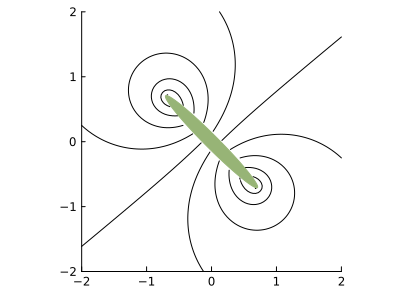

In [11]:
Żr = -1.0+0.0im # translational velocity
α̇ = 0.0 # angular velocity
motion = RigidBodyMotion(Żr, α̇)
sys = ()

clear_images!(b)
enforce_no_flow_through!(b, motion, sys, t)
ps = streamlines(xg,yg,ζg,(b,sys),levels=range(-2,2,length=31),xlim=(-2,2),ylim=(-2,2))
plot!(ps,b)

Notice how different these streamlines look compared to previous example. It is not obvious that
they correspond to the same flow. It raises the important point that **streamlines
depend on the frame of reference in which the flow is viewed**. In this
reference frame, the flow is quiescent at infinity, and all of the motion
is generated in the vicinity of the body. Notice how it curls back around the
edges. That is characteristic of the streamlines due to body motion,
because there must be some way for the fluid to "fill in" the region behind
the moving body.

## Now put them together
Let's put a vortex near a stationary body in a uniform flow.

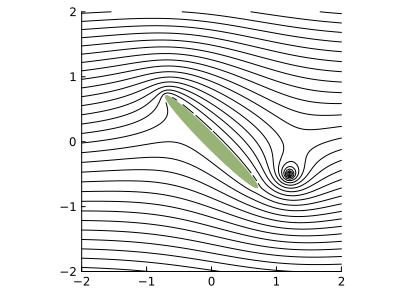

In [12]:
Żr = 0.0+0.0im # translational velocity
α̇ = 0.0 # angular velocity
motion = RigidBodyMotion(Żr, α̇)

Winf = 1.0
fs = Freestreams.Freestream(conj(Winf))

zv = 1.2-0.5im
Γv = 2.5
vort_z = Vortex.Point(zv, Γv)

sys = (vort_z,fs)
sys = inverse_conftransform(sys,b) # Inverse-transform them

clear_images!(b)
enforce_no_flow_through!(b, motion, sys, t)
ps = streamlines(xg,yg,ζg,(b,sys),levels=range(-2,2,length=31),xlim=(-2,2),ylim=(-2,2))
plot!(ps,b)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*